In [55]:
import pandas as pd
import numpy as np 
import seaborn as sns
import csv
import matplotlib.pyplot as plt 
import collections
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from collections import Counter
from sklearn.model_selection import train_test_split

### Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

### Gridsearch
from pprint import pprint
from time import time
import logging
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
#Loading Data
train = pd.read_csv("train_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)
test = pd.read_csv("test_data_w_ingredients.csv", sep=';', error_bad_lines=False, index_col=0)

In [57]:
train.drop(["index"], axis=1, inplace=True)
train.drop(["name"], axis=1, inplace=True)
test.drop(["index"], axis=1, inplace=True)
test.drop(["name"], axis=1, inplace=True)

In [58]:
print("Document Count")
print(train.groupby('cuisine').count())

Document Count
            ingredients
cuisine                
Chinese              60
Greek                50
Iberic               40
Italian              50
Thai                 50
Vietnamese           50
french               50
korean               50


In [59]:
european = ["Italian","Iberic","french","Greek"]

def continental (row):
    if row['cuisine'] in european:
        return 'european'
    return 'asian'

train["continental"]=train.apply(lambda row: continental(row), axis=1)
train.sample(15)

,ingredients,cuisine,continental
168,"['1 package Impossible™ Burger', '2 cloves gar...",korean,asian
183,"['1 pound chicken (boneless, skinless thighs, ...",korean,asian
52,"['1/4 cup extra-virgin olive oil', '1/4 cup fr...",Greek,european
268,"['1 quart low sodium chicken broth', '2 stalks...",Thai,asian
18,"['2 cups beef stock', '1 cinnamon (quill)', '2...",Vietnamese,asian
138,"['2 pounds Great Northern Beans (dried)', '6 c...",french,european
305,"['2 cloves garlic (minced)', '1 tablespoon fre...",Chinese,asian
66,"['1 cup elbow macaroni (uncooked)', '1 pound g...",Greek,european
63,"['1,100 grams octopus (cleaned, 35 ounces)', '...",Greek,european
104,"['4 yellow onions (large)', '2 sweet onions (l...",french,european


In [60]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 


def preprocess(text):
    text=str(text) #stringify
    text = text.lower() #kleinschreibung
    text = re.sub("\(.*?\)","()",text) #Alternativen entfernen - also alles zwischen ( )
    text=text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words] 
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(lemma_words)


# Apply to the DF series
train['cleanText']=train['ingredients'].map(lambda s:preprocess(s)) 
train.drop(["ingredients"], axis=1, inplace=True)
test['cleanText']=test['ingredients'].map(lambda s:preprocess(s)) 
test.drop(["ingredients"], axis=1, inplace=True)
train.head(3)

,cuisine,continental,cleanText
1,Vietnamese,asian,cup beef broth cup water yellow onion clove ga...
2,Vietnamese,asian,pound ground chicken tablespoon fish sauc onio...
3,Vietnamese,asian,pound pork blade steak tablespoon light brown ...


In [75]:
train["cleanText"].iloc[0]

'cup beef broth cup water yellow onion clove garlic whole star ani whole clove ginger cinnamon stick tablespoon fish sauc salt black pepper packag rice noodl ounc steak bean sprout fresh cilantro fresh ginger lime wedg green onion jalapeno thai basil'

In [62]:
d = Counter(" ".join(train["cleanText"]).split()).most_common()

all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
all_recipes_df

,ingredient,overall_count
0,tablespoon,1059
1,cup,985
2,teaspoon,855
3,oil,361
4,sauc,327
...,...,...
647,poppi,1
648,sweeten,1
649,condens,1
650,full,1


In [63]:
d = Counter(" ".join(asian_recipes["cleanText"]).split()).most_common()

asian_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['asian_ingredient','asian_count'])
asian_recipes_df

,asian_ingredient,asian_count
0,tablespoon,715
1,cup,480
2,teaspoon,440
3,sauc,302
4,oil,210
...,...,...
401,lite,1
402,chestnut,1
403,almond,1
404,xanthan,1


In [59]:
d = Counter(" ".join(european_recipes["cleanText"]).split()).most_common()

european_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['european_ingredient','european_count'])
european_recipes_df

,european_ingredient,european_count
0,cup,505
1,teaspoon,415
2,tablespoon,344
3,salt,196
4,pepper,182
...,...,...
475,condens,1
476,full,1
477,blade,1
478,free,1


In [76]:
cuisine_names = list(train['cuisine'].value_counts().index)
cuisine_names

['Chinese',
 'french',
 'Thai',
 'Vietnamese',
 'Italian',
 'Greek',
 'korean',
 'Iberic']

In [78]:
continental_names = list(train['continental'].value_counts().index)
continental_names

['asian', 'european']

In [141]:
test = all_recipes_df

for cuisine in continental_names:
    df = train.loc[train['continental'] == cuisine]
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
    test = pd.merge(test, count_df, on='ingredient', how='left')
    
    
for cuisine in cuisine_names:
    df = train.loc[train['cuisine'] == cuisine]
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()

    count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
    test = pd.merge(test, count_df, on='ingredient', how='left')
    

test

,ingredient,overall_count,asian,european,Chinese,french,Thai,Vietnamese,Italian,Greek,korean,Iberic
0,tablespoon,1059,715.0,344.0,191.0,126.0,199.0,134.0,76.0,96.0,191.0,46.0
1,cup,985,480.0,505.0,145.0,144.0,115.0,110.0,151.0,139.0,110.0,71.0
2,teaspoon,855,440.0,415.0,154.0,106.0,94.0,68.0,85.0,161.0,124.0,63.0
3,oil,361,210.0,151.0,76.0,34.0,38.0,27.0,32.0,50.0,69.0,35.0
4,sauc,327,302.0,25.0,89.0,2.0,80.0,78.0,17.0,2.0,55.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
647,poppi,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
648,sweeten,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
649,condens,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
650,full,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [218]:
indexList = []
for cuisine in continental_names:
    indexNames = test[ test[cuisine] >= 2 ].index
    print(cuisine)
    print(indexNames)
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

test.drop(indexList , inplace=True)
remove_list = test['ingredient'].tolist()

KeyError: 'asian'

In [121]:
indexList = []
for cuisine in cuisine_names:
    indexNames = test[ test[cuisine] <= 2 ].index
    print(indexNames)
    for i in indexNames:        
        if i in indexList:
            pass
        else:
            indexList.append(i)
            
            

test.drop(indexList , inplace=True)
remove_list = test['ingredient'].tolist()
len(remove_list)

Int64Index([ 27,  34,  42,  56,  61,  63,  70,  74,  84,  88,  91,  95,  96,
            105, 108, 109, 117, 122, 123, 128, 130, 139, 151, 153, 154, 179,
            180, 181, 183, 186, 198, 201, 207, 214, 220, 223, 225, 242, 262,
            267, 268, 284, 287, 288, 298, 306, 332, 336, 338, 344, 351, 401,
            404, 409, 417, 418, 419, 420, 619, 620, 621, 622, 623, 624],
           dtype='int64')
Int64Index([  4,  23,  40,  66,  69,  72,  74,  78,  87,  99,
            ...
            510, 511, 512, 513, 514, 515, 516, 517, 518, 519],
           dtype='int64', length=159)
Int64Index([ 16,  27,  39,  41,  52,  56,  57,  58,  59,  62,
            ...
            609, 610, 611, 612, 613, 614, 615, 616, 617, 618],
           dtype='int64', length=131)
Int64Index([ 26,  27,  41,  50,  52,  54,  65,  70,  74,  75,
            ...
            446, 447, 448, 449, 450, 451, 452, 453, 454, 455],
           dtype='int64', length=132)
Int64Index([ 28,  31,  32,  33,  40,  45,  49,  69,  70,

71

In [155]:
train.head(5)

,cuisine,continental,cleanText
1,Vietnamese,asian,cup beef broth cup water yellow onion clove ga...
2,Vietnamese,asian,pound ground chicken tablespoon fish sauc onio...
3,Vietnamese,asian,pound pork blade steak tablespoon light brown ...
4,Vietnamese,asian,pound chicken thigh tablespoon oil clove garli...
5,Vietnamese,asian,marrow bone ounc beef stock ounc water onion g...


In [11]:
def generate_remove_list(df, min_overall_count, min_count_in_cuisine):
    
    indexList = []
    
    cuisine_names = list(df['cuisine'].value_counts().index)
    continental_names = list(df['continental'].value_counts().index)
    
    d = Counter(" ".join(df["cleanText"]).split()).most_common()
    all_recipes_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient','overall_count'])
    words_df = all_recipes_df
    
    for cuisine in continental_names:
        df = train.loc[train['continental'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
    
    
    for cuisine in cuisine_names:
        df = train.loc[train['cuisine'] == cuisine]

        d = Counter(" ".join(df["cleanText"]).split()).most_common()

        count_df = pd.DataFrame.from_records(list(dict(d).items()), columns=['ingredient', cuisine])
        words_df = pd.merge(words_df, count_df, on='ingredient', how='left')
        
    
    for cuisine in continental_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_overall_count ].index
        
        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)
    
    for cuisine in cuisine_names:
        indexNames = []
        indexNames = words_df[ words_df[cuisine] <= min_count_in_cuisine ].index

        for i in indexNames:        
            if i in indexList:
                pass
            else:
                indexList.append(i)




    words_df.drop(indexList , inplace=True)
    
    remove_list = words_df['ingredient'].tolist()
    

    
    
    return remove_list
    

        
        
    


In [220]:
remove_list = generate_remove_list(train, 1 , 1)
len(remove_list)

162

In [12]:
def remove_common_words(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in remove_list]
    return " ".join(filtered_words)

In [ ]:
train['cleanText_removed']=train['cleanText'].map(lambda s:remove_common_words(s)) 
train.head(1)

In [174]:
rows_list = []

def test_classifier_with_remove(clf,name):
    for i in [1,2,3,5,10,100, 1000]:
        for e in [1,2,3,5,10,100, 1000]:
            test = train

            remove_list = generate_remove_list(test, i , e)
            len_remove_list = len(remove_list)

            test['cleanText_removed']=test['cleanText'].map(lambda s:remove_common_words(s))

            X = test['cleanText_removed']
            Y = test['cuisine']
            x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                                test_size=.2, 
                                                                random_state=8)


            pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('clf', clf),
                                ])

            pipeline.fit(x_train, y_train)

            y_pred = pipeline.predict(x_test)
            score = accuracy_score(y_pred, y_test)

            dict1 = {
                        "Length of remove_list": len_remove_list,
                        "Accuracy": score,
                        "Removed words": remove_list,
                        "Classifier": name,
                        "Method": "auto"
                    }
            rows_list.append(dict1)

        


In [175]:
names = ["Nearest Neighbors",
         "Linear SVM",
         "RBF SVM",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost",
         "multinomial Naive Bayes",
         "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    MultinomialNB(),
    SGDClassifier()]

In [176]:
for name, clf in zip(names, classifiers):
    test_classifier_with_remove(clf,name)
    
result = pd.DataFrame(rows_list)

In [177]:
result.sample(9)

,Length of remove_list,Accuracy,Removed words,Classifier,Method
384,0,0.7375,[],multinomial Naive Bayes,auto
53,18,0.8250,"[tablespoon, cup, teaspoon, oil, pepper, garli...",Linear SVM,auto
340,0,0.4375,[],AdaBoost,auto
212,46,0.4000,"[tablespoon, cup, teaspoon, oil, pepper, garli...",Random Forest,auto
51,46,0.8250,"[tablespoon, cup, teaspoon, oil, pepper, garli...",Linear SVM,auto
79,29,0.8250,"[tablespoon, cup, teaspoon, oil, pepper, garli...",Linear SVM,auto
397,0,0.7875,[],SGD,auto
366,36,0.7375,"[tablespoon, cup, teaspoon, oil, pepper, garli...",multinomial Naive Bayes,auto
244,0,0.3500,[],Random Forest,auto


<AxesSubplot:xlabel='Length of remove_list', ylabel='Accuracy'>

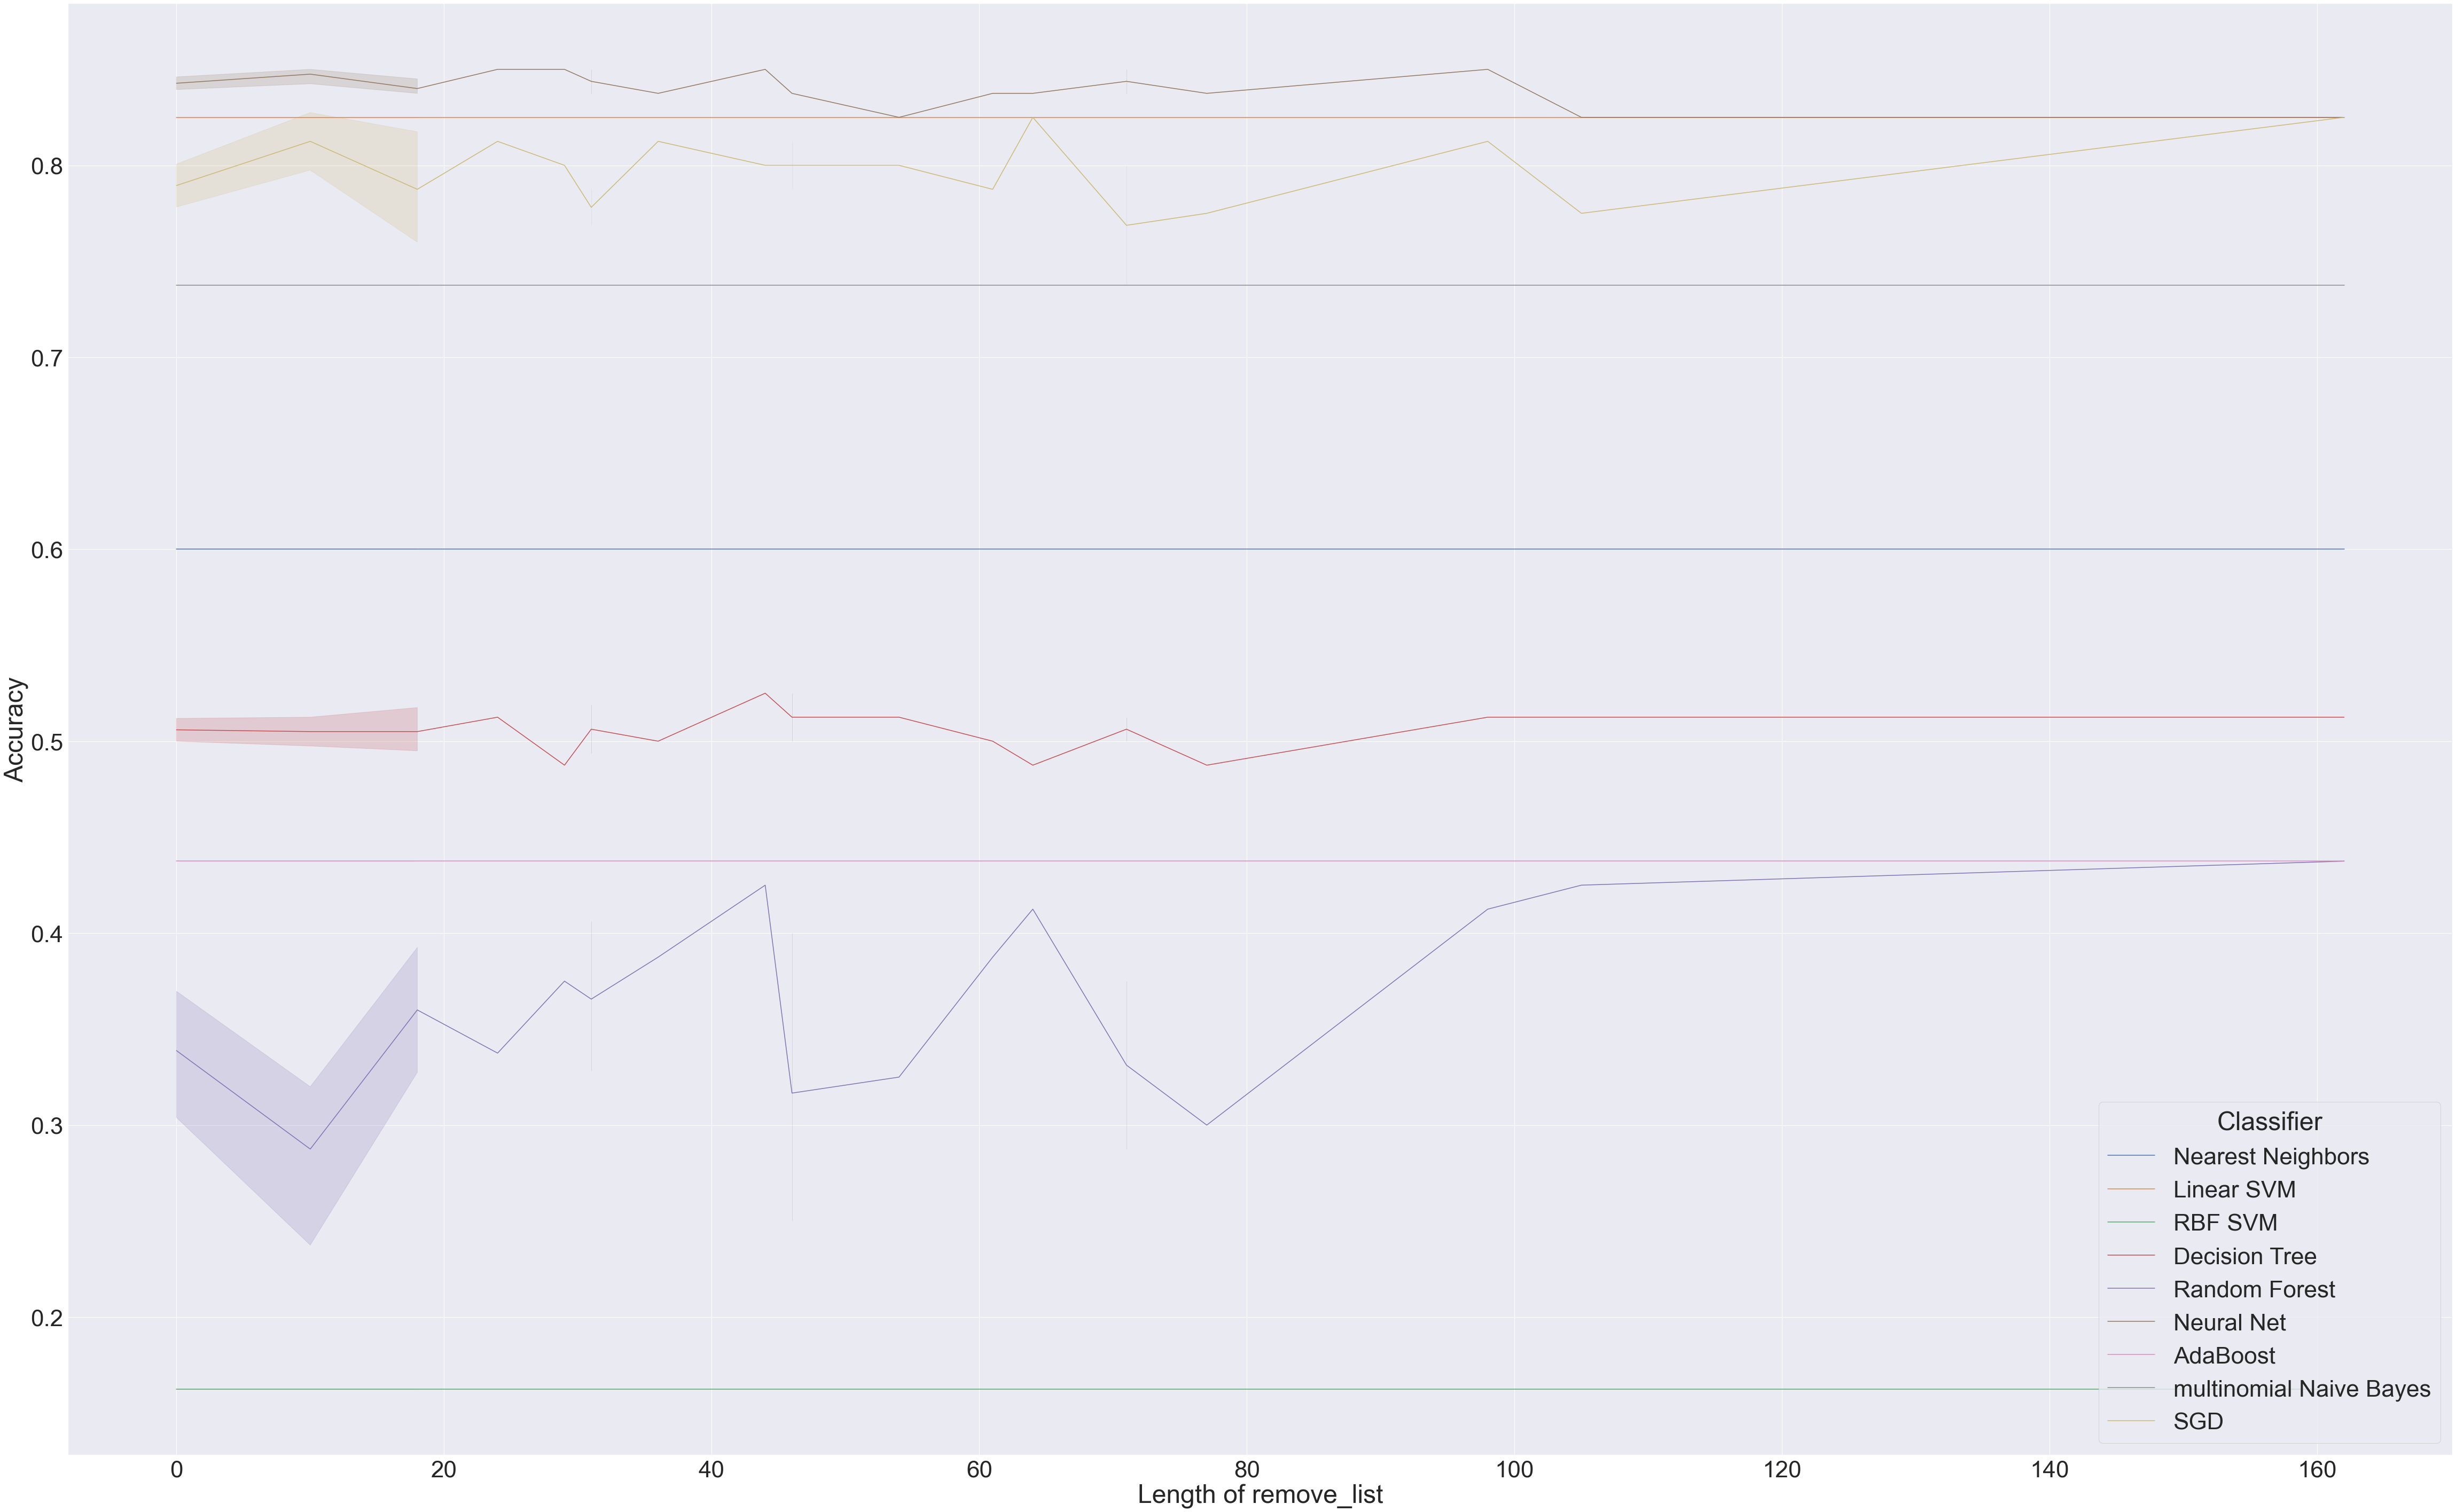

In [178]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
sns.lineplot(
    data=result, 
    x="Length of remove_list", y="Accuracy", hue="Classifier",
)

In [181]:
sorted_result= result.groupby('Classifier').agg({'Accuracy': 'max'}).reset_index()

sorted_result

,Classifier,Accuracy
0,AdaBoost,0.4375
1,Decision Tree,0.5250
2,Linear SVM,0.8250
3,Nearest Neighbors,0.6000
4,Neural Net,0.8500
5,RBF SVM,0.1625
6,Random Forest,0.4500
7,SGD,0.8375
8,multinomial Naive Bayes,0.7375


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

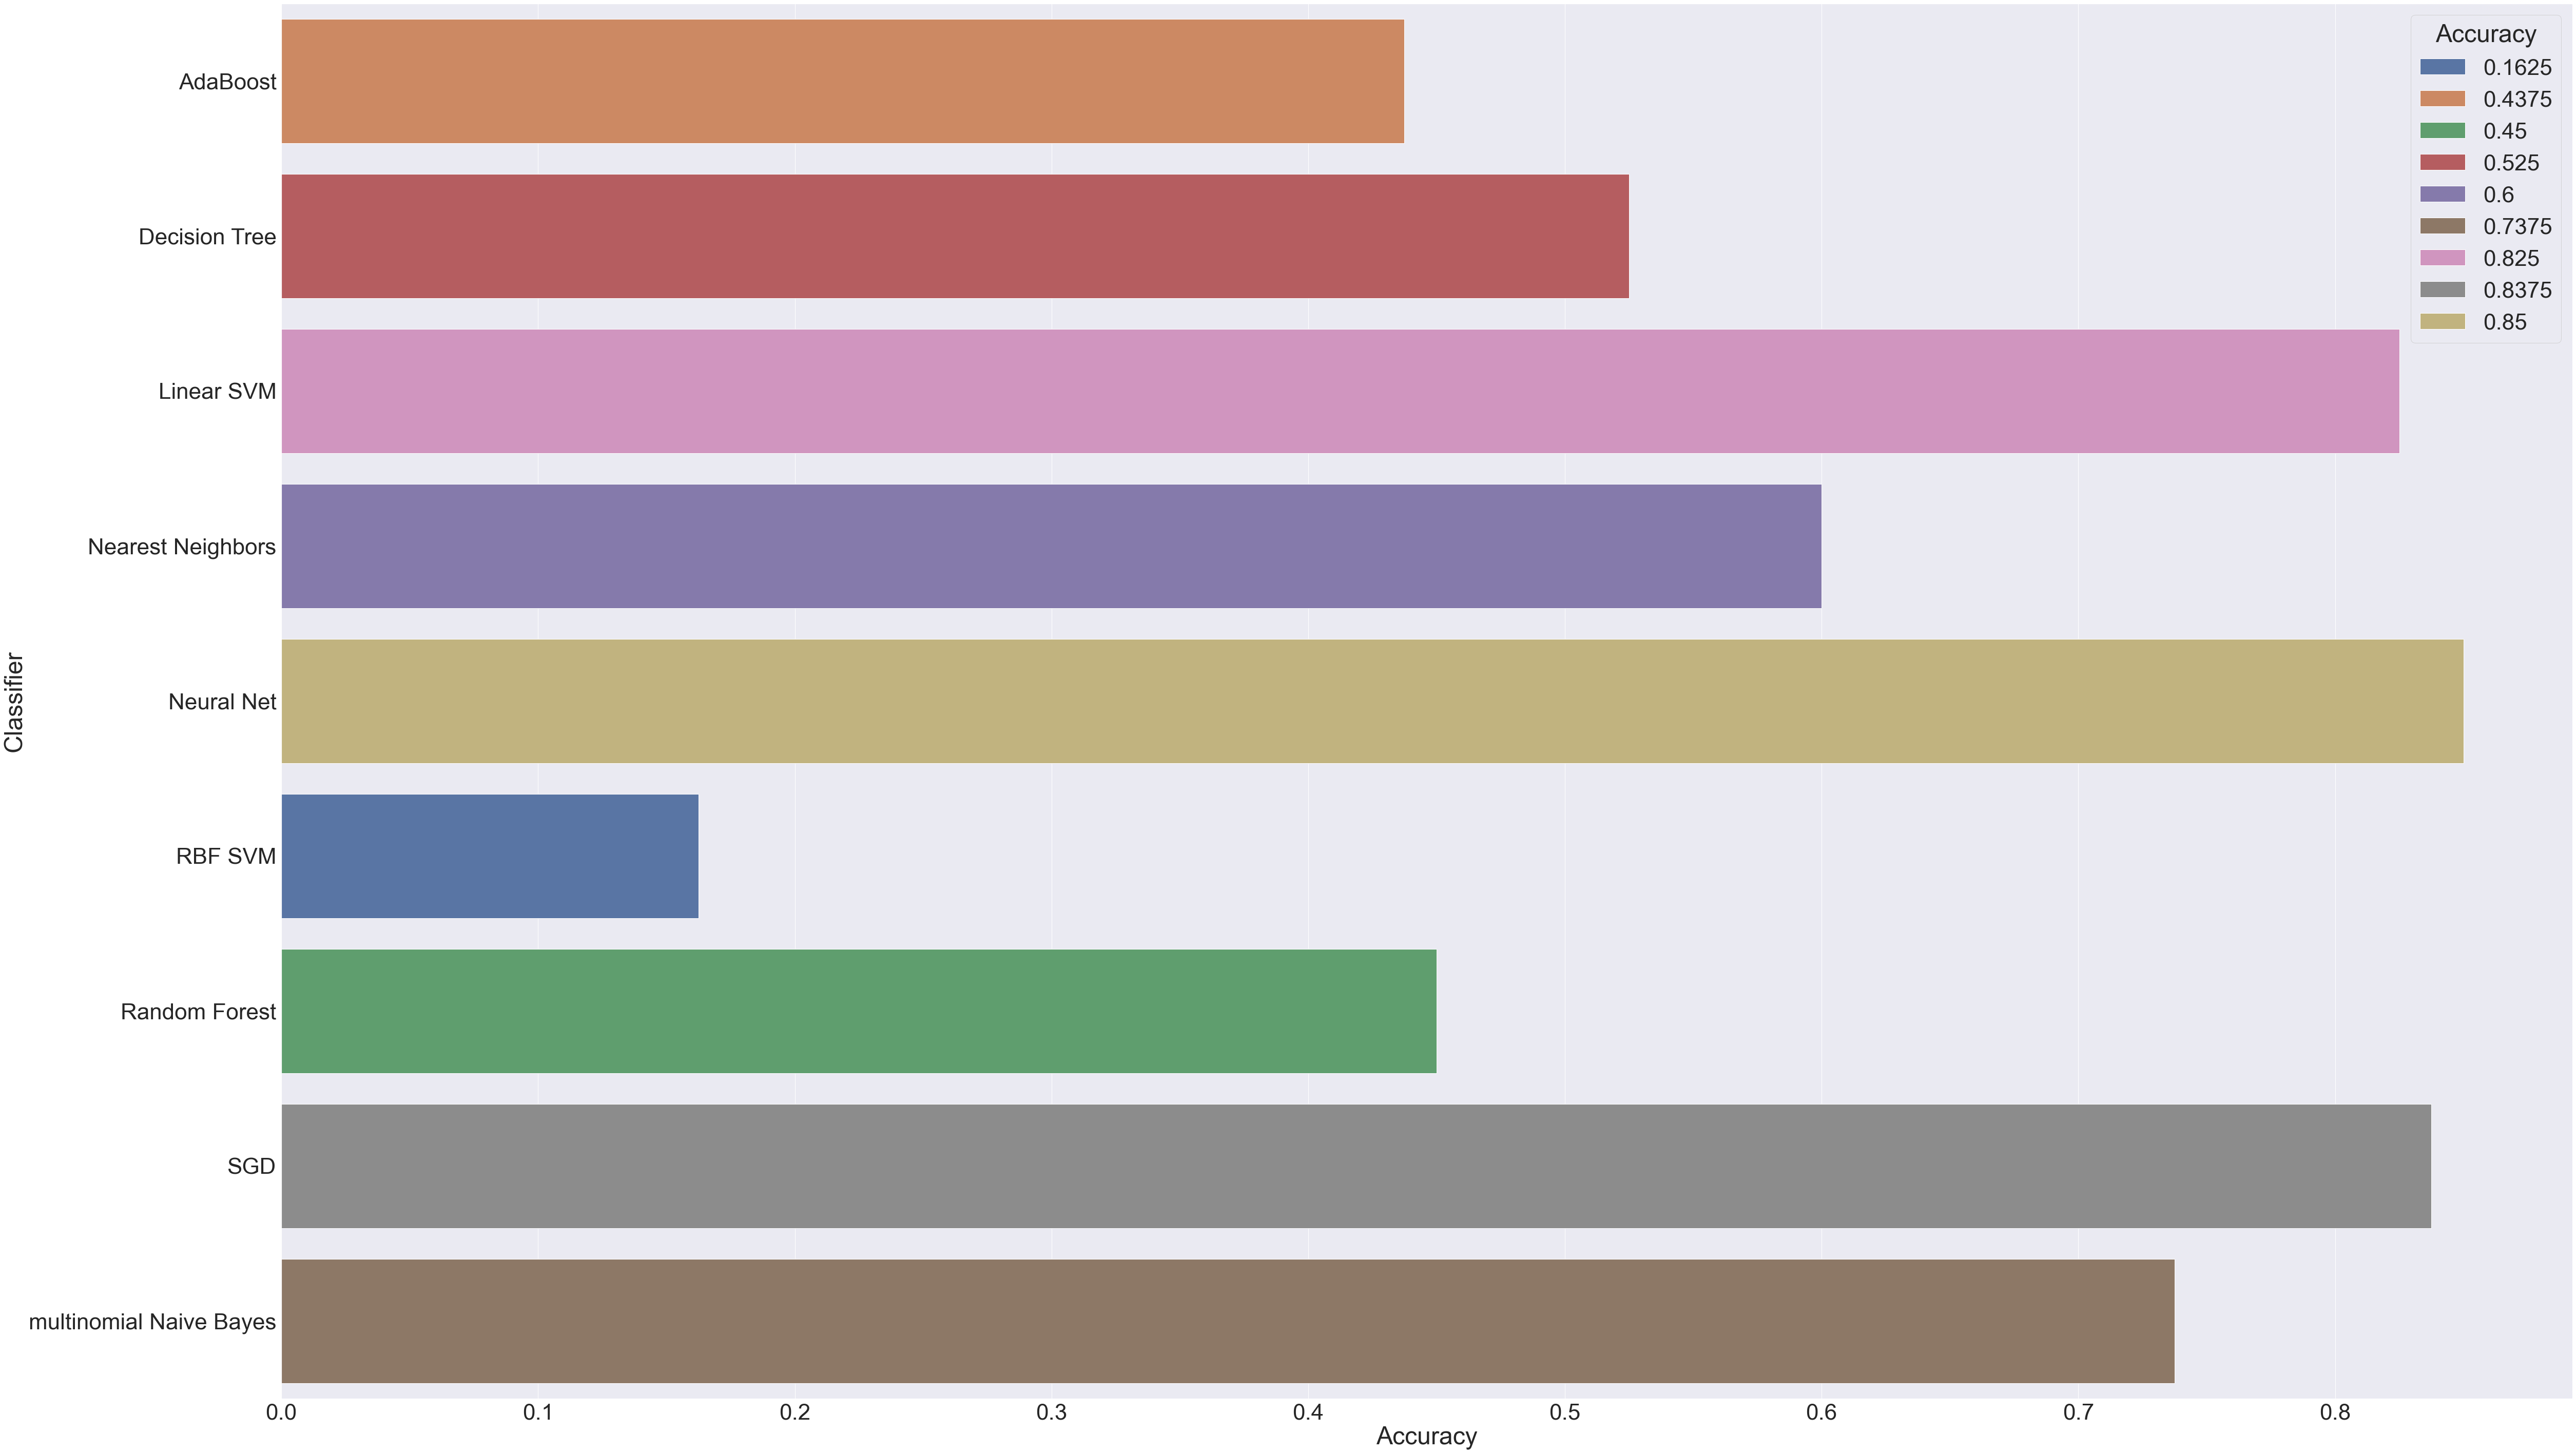

In [182]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=sorted_result, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

In [186]:
tfidf_rows_list = []
X = train['cleanText']
Y = train['cuisine']
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=.2, 
                                                    random_state=8)


# iterate over classifiers
for name, clf in zip(names, classifiers):

    pipeline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', clf),
              ])
    pipeline.fit(x_train, y_train)
    
    y_pred = pipeline.predict(x_test)
    score = accuracy_score(y_pred, y_test)

    dict1 = {
                "Classifier": name,
                "Accuracy": score,
                "Method": "tfidf"

            }
    tfidf_rows_list.append(dict1)
    
    
result_tfidf = pd.DataFrame(tfidf_rows_list)
result_tfidf.head()

,Classifier,Accuracy,Method
0,Nearest Neighbors,0.7375,tfidf
1,Linear SVM,0.1250,tfidf
2,RBF SVM,0.8250,tfidf
3,Decision Tree,0.4875,tfidf
4,Random Forest,0.2750,tfidf


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

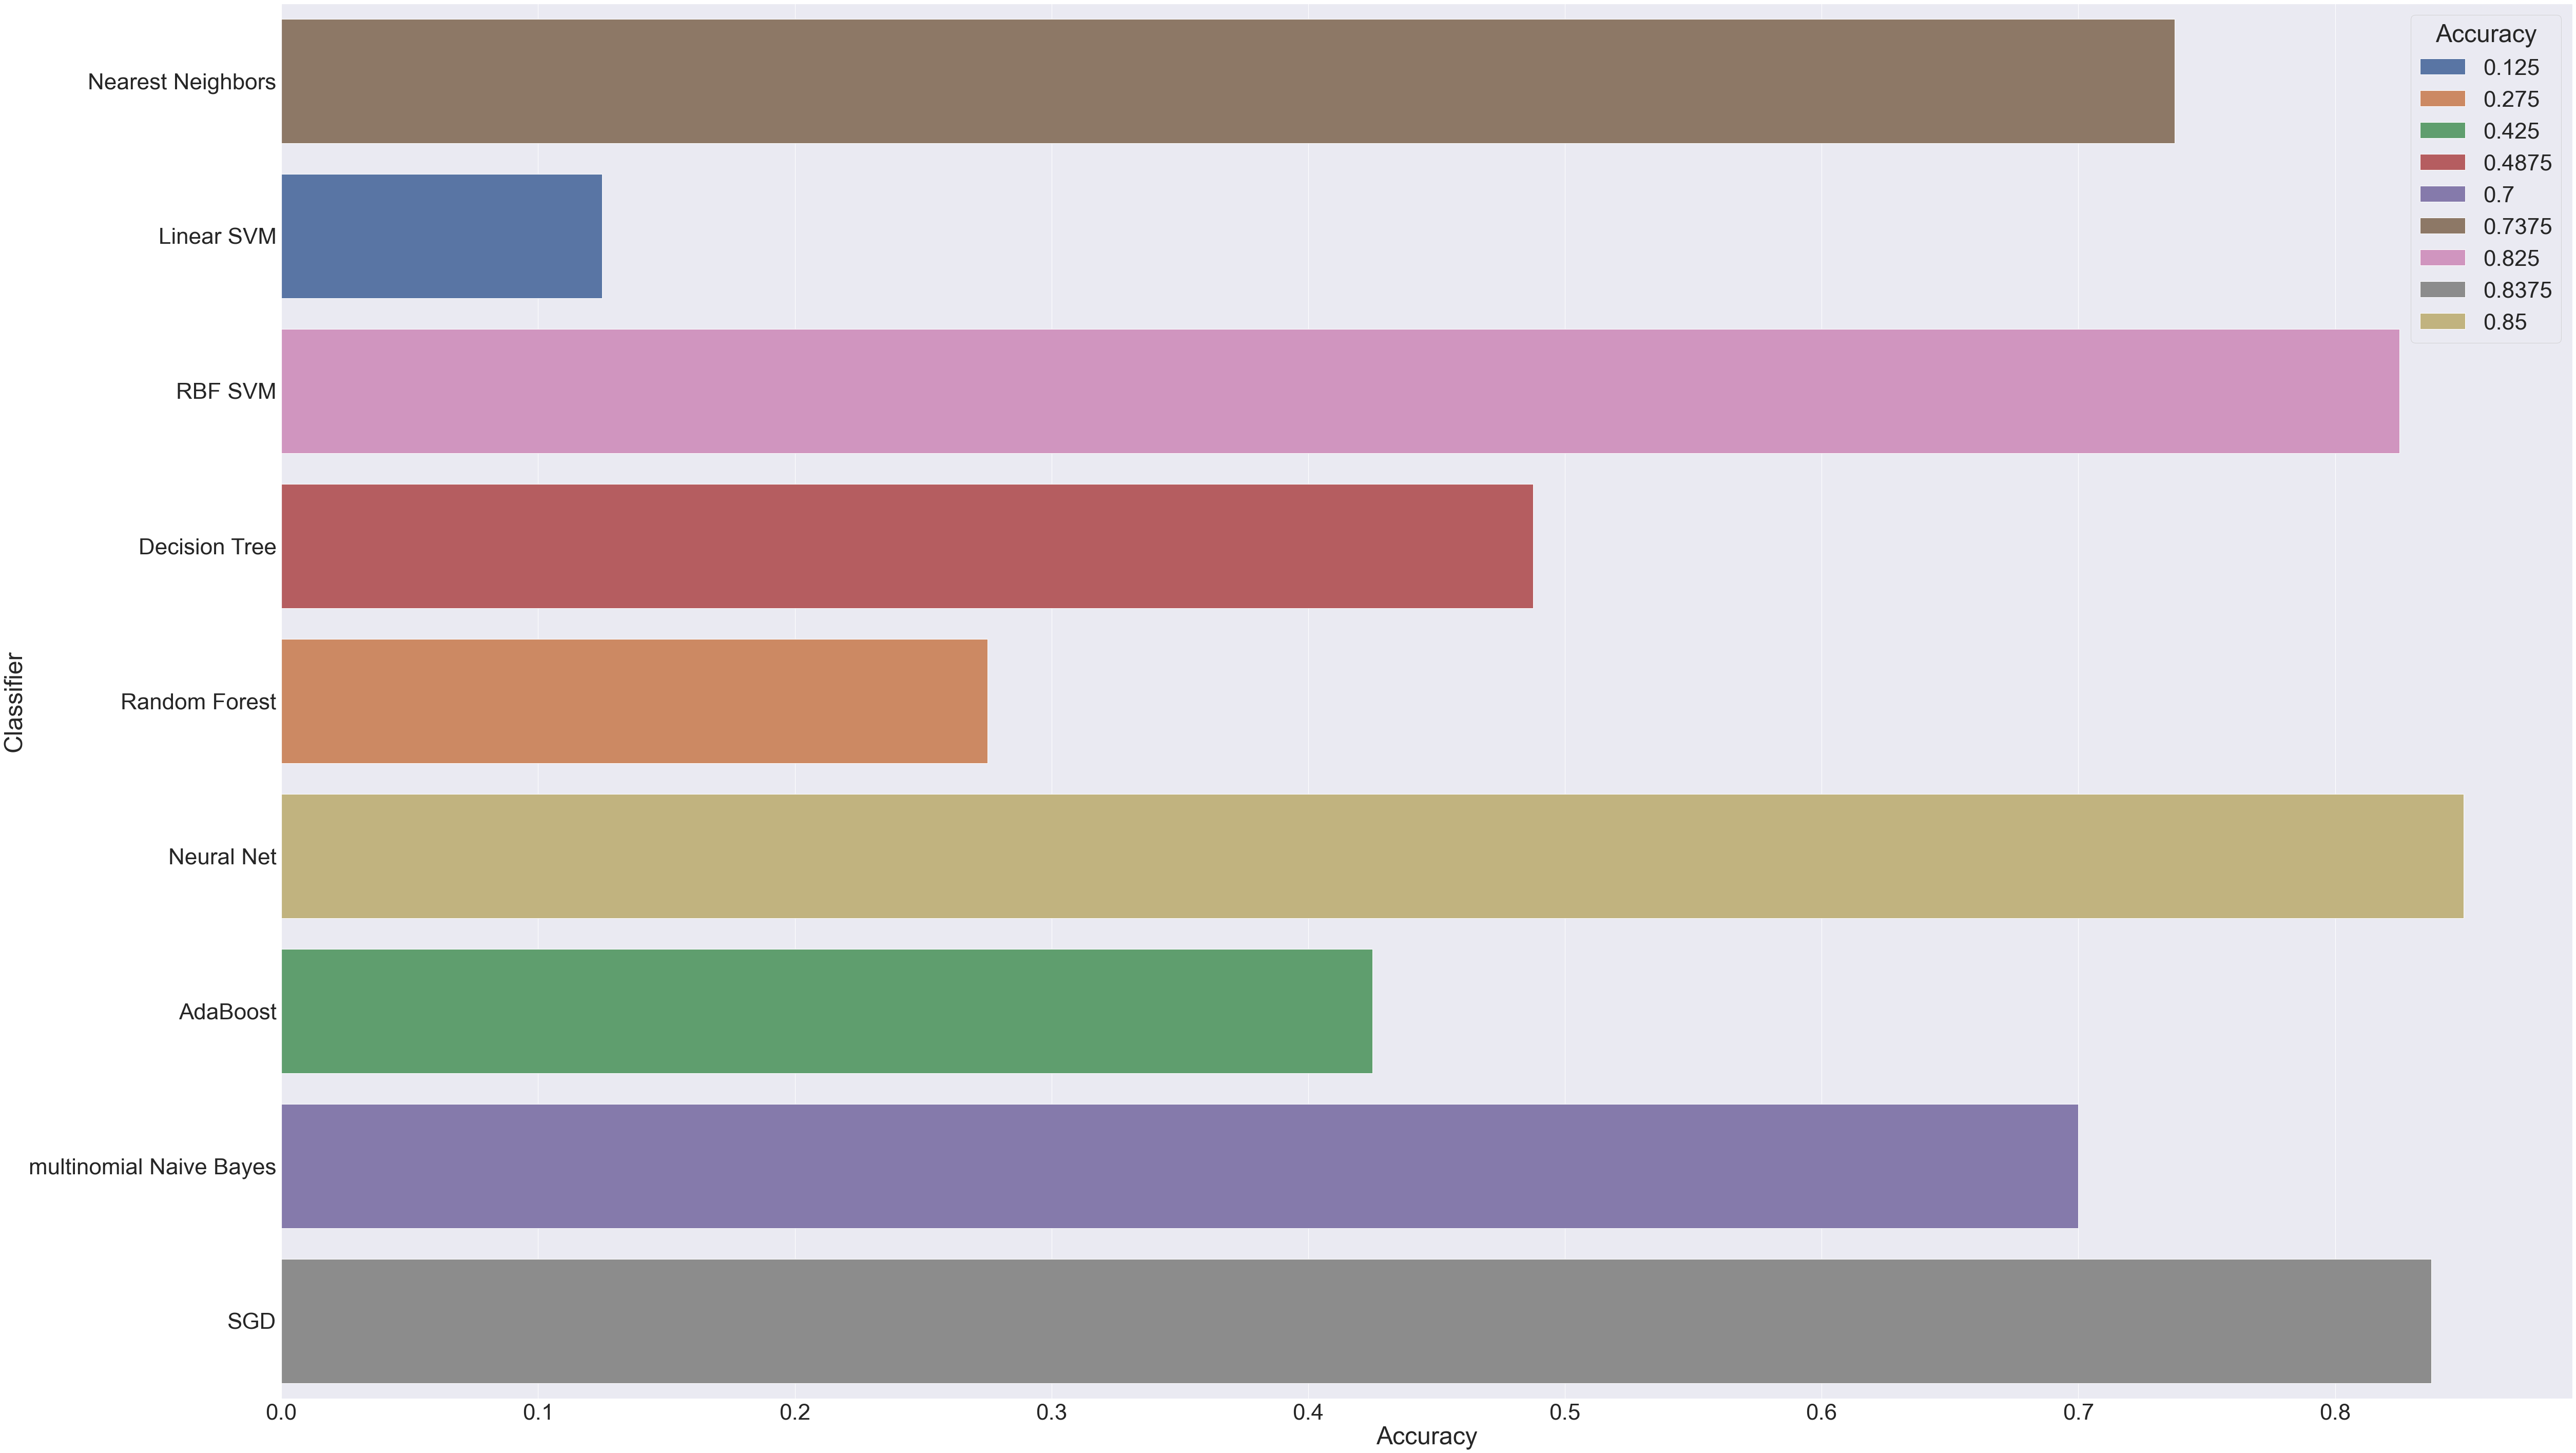

In [187]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=result_tfidf, 
    x="Accuracy", y="Classifier", hue="Accuracy",dodge=False
)

In [202]:
all_classifier_combinations = sorted_result.append(result_tfidf, sort=False)


all_classifier_combinations['Method'] = all_classifier_combinations['Method'].fillna("auto")

all_classifier_combinations

,Classifier,Accuracy,Method
0,AdaBoost,0.4375,auto
1,Decision Tree,0.5250,auto
2,Linear SVM,0.8250,auto
3,Nearest Neighbors,0.6000,auto
4,Neural Net,0.8500,auto
5,RBF SVM,0.1625,auto
6,Random Forest,0.4500,auto
7,SGD,0.8375,auto
8,multinomial Naive Bayes,0.7375,auto
0,Nearest Neighbors,0.7375,tfidf


<AxesSubplot:xlabel='Accuracy', ylabel='Classifier'>

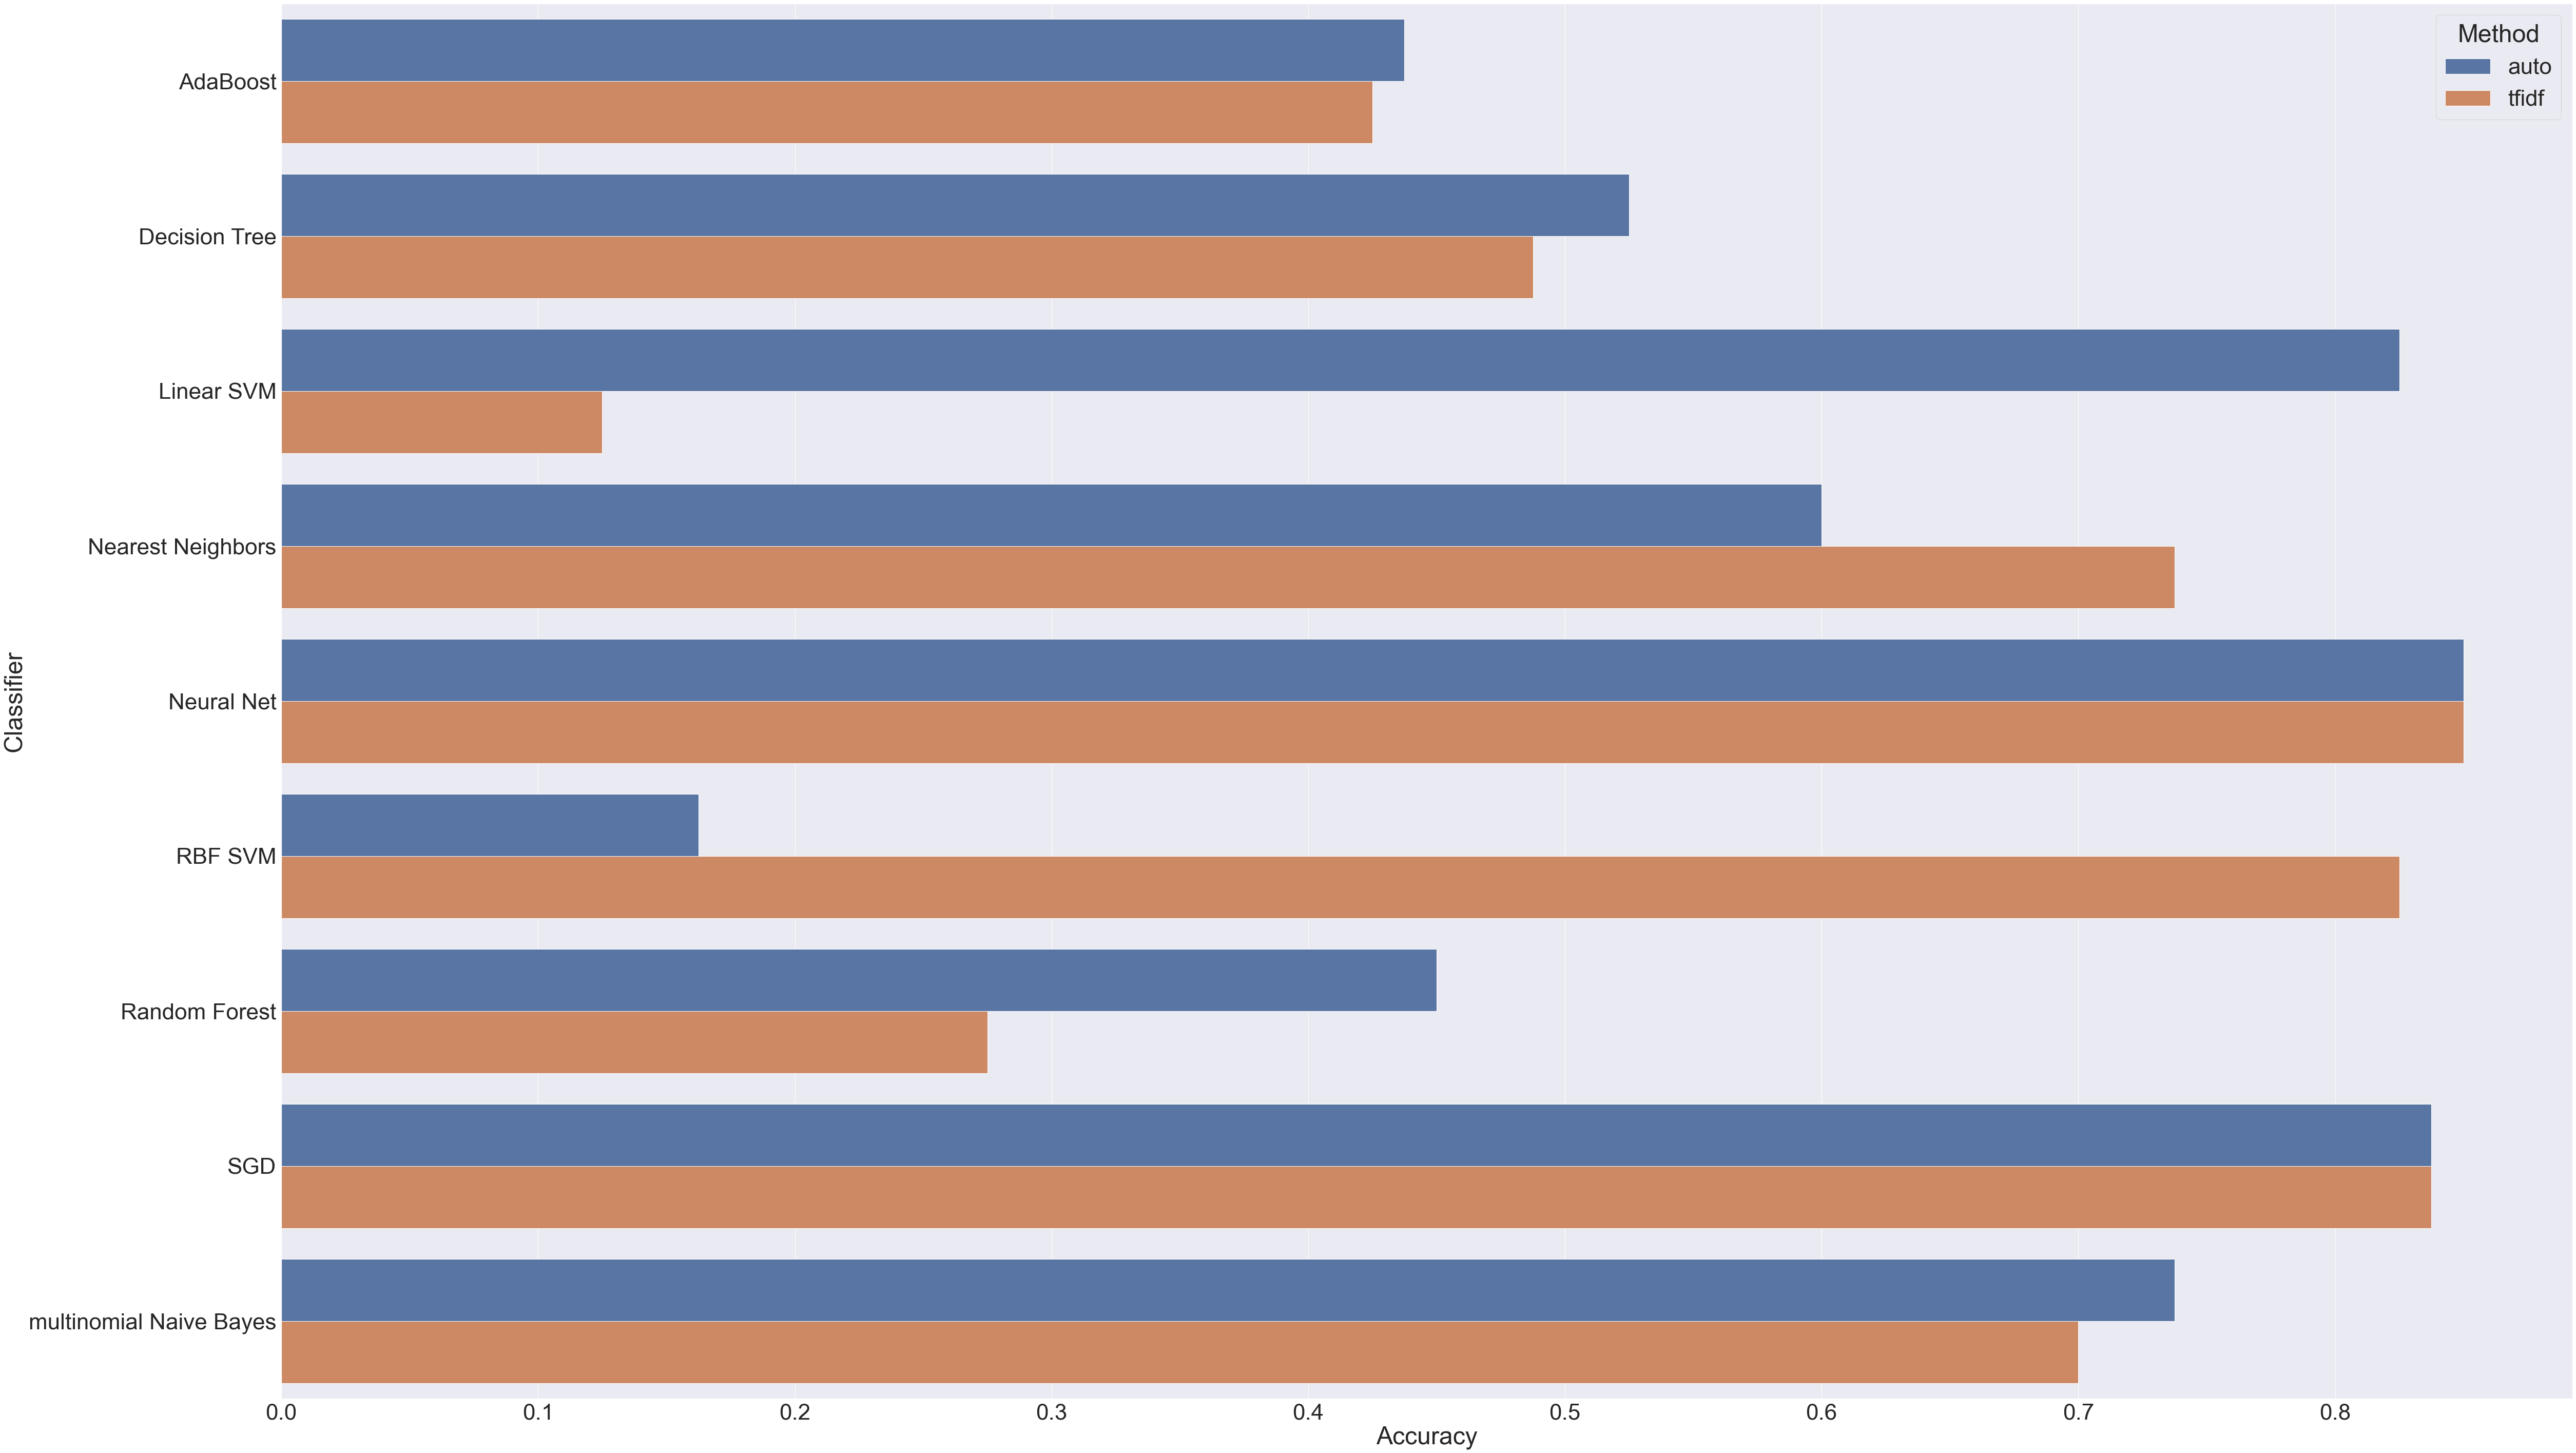

In [204]:
sns.set(font_scale=4)
plt.figure(figsize=(80, 50))
plt.tight_layout()
sns.barplot(
    data=all_classifier_combinations, 
    x="Accuracy", y="Classifier", hue="Method"
)

In [227]:
for method in ["auto", "tfidf"]:
    best = all_classifier_combinations.loc[all_classifier_combinations["Method"] == method]
    best = best.loc[best["Accuracy"] >= 0.8]
    mean = all_classifier_combinations.loc[all_classifier_combinations["Method"] == method]
    mean = mean["Accuracy"].mean()
    print("Method: " + method)
    print(best)
    print( "Mean of Method: " + str(mean))
    print()

Method: auto
   Classifier  Accuracy Method
2  Linear SVM    0.8250   auto
4  Neural Net    0.8500   auto
7         SGD    0.8375   auto
Mean of Method: 0.6027777777777779

Method: tfidf
   Classifier  Accuracy Method
2     RBF SVM    0.8250  tfidf
5  Neural Net    0.8500  tfidf
8         SGD    0.8375  tfidf
Mean of Method: 0.5847222222222223



In [68]:
rbf_svm = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(gamma=2, C=1)),
              ])
rbf_svm.fit(x_train, y_train)

y_pred = rbf_svm.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.825
              precision    recall  f1-score   support

     Chinese       0.89      0.80      0.84        10
       Greek       0.94      1.00      0.97        15
      Iberic       0.83      0.62      0.71         8
     Italian       0.78      0.88      0.82         8
        Thai       0.67      0.75      0.71         8
  Vietnamese       0.90      0.75      0.82        12
      french       0.62      0.83      0.71         6
      korean       0.85      0.85      0.85        13

    accuracy                           0.82        80
   macro avg       0.81      0.81      0.80        80
weighted avg       0.83      0.82      0.82        80



In [69]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

data = train


# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
# max combinations: 3x4x2x2x2x4x2x2= 1536
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1, 10, 100, 1000),
    'clf__gamma': (0.001, 0.0001,1, 2),
    'clf__kernel': ('linear', 'rbf'), 
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.cleanText, data.cuisine)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (1, 10, 100, 1000),
 'clf__gamma': (0.001, 0.0001, 1, 2),
 'clf__kernel': ('linear', 'rbf'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  4.3min


done in 308.862s

Best score: 0.825
Best parameters set:
	clf__C: 10
	clf__gamma: 1
	clf__kernel: 'rbf'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 1)


[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed:  5.1min finished
